# Astro 528, Lab 7, Exercise 2
## Parallelization for Cluster using Distributed-Memory Model

In this lab exercise, we'll perform the calculations very similar to those of exercise 2 of lab 5.  However, instead of using a multi-core workstation, we will [run the calculations on the ICDS Roar Collab cluster](https://www.icds.psu.edu/roar-collab-user-guide/) using a distributed memory model.  

You're welcome to run this notebook one cell at a time as in other labs to see how it works.  However, the main point of this lab is to see how to run such a calculation in parallel over multiple processor cores that are not necessarily on the same processor.  Therefore, you'll use the command line interface to submit the jobs [ex2.pbs](https://github.com/PsuAstro528/lab7-start/blob/main/ex2.slurm).  Follow the instructions in the [lab's README](https://github.com/PsuAstro528/lab7-start/blob/main/README.md)

In [1]:
# Just in case you're running this from JupyterLab
import Pkg
Pkg.UPDATED_REGISTRY_THIS_SESSION[] = true   
Pkg.activate(".")
# Shouldn't need to instantiate the project, since you'll have already run as part of exercise 1.  But I'll default to running it just in case.
Pkg.instantiate()
# Again, just being extra careful to make sure everything is precompiled by delegator process before assigning work to worker proceses
Pkg.precompile()

  Activating project at `/storage/work/ebf11/Teach/Astro528/Fall2023/lab7-start`
Precompiling project...
  ✓ Plots → UnitfulExt
  1 dependency successfully precompiled in 6 seconds. 200 already precompiled.


Remember, packages are installed to disk and the Roar Collab nodes all see the same file systems, so you only want to run `instantiate` and `precompile` once by the delegator process, so multiple workers don't try to compile the same package at the same time.


### Getting setup for parallel computation
First, we'll load Julia's `Distributed` module that provides much of the needed functionality for multi-processing.  If julia doesn't already have multiple worker threads, then we'll try to start some. 

In [2]:
using Distributed, CpuId
println("# Julia is using ", nworkers(), " workers.")

# Julia is using 1 workers.


In [3]:
if nworkers() == 1
    if haskey(ENV,"SLURM_CPUS_PER_TASK")
        @warn "Since there's only one worker, I'm guessing you're running this from inside JupyterLab rather than a dedicated slurm job."
        cores_for_job = parse(Int,ENV["SLURM_CPUS_PER_TASK"])
        addprocs(cores_for_job)
    elseif haskey(ENV,"GITHUB_ACTION")   
        @warn "Not adding any worker processes since running on GitHub."
    else 
        @warn "It appears this is not running on Roar Collab.  So we'll add one worker process for each physical core."
        addprocs(cpucores())
    end
end

┌ Warning: Since there's only one worker, I'm guessing you're running this from inside JupyterLab rather than a dedicated slurm job.
└ @ Main In[3]:3


4-element Vector{Int64}:
 2
 3
 4
 5

In [4]:
println("# Now Julia is using ", nworkers(), " workers.")

# Now Julia is using 4 workers.


### Loading Packages and modules
Now, we can start loading other packages that we'll be using for our actual calculations.  
First, we'll load the CSV and DataFrames packages that only need to be loaded by the delegator process.


In [5]:
using CSV, DataFrames

For other packages (here Distributions, DistributedArrays and ParallelDataTransfer), we want the packages to be in scope on each worker.  Therefore, need to add the `@everywhere` macro in front of the `using` statement.  

In [6]:
@everywhere using Distributions
@everywhere using DistributedArrays
@everywhere using ParallelDataTransfer

For this lab, I've written several functions that will be used to generate simulated spectra.  This serves a couple of purposes.
First, you'll use the code in the exercise, so you have a calculation that's big enough to be worth parallelizing.  For the purposes of this exercise, it's not essential that you review the code I provided in `.jl` files.  However, the second purpose of providing this is to demonstrate several of the programming patterns that we've discussed in class.  For example, the code in the `lab7` module
- is in the form of several small functions, each which does one specific task.  
- has been moved out of the Jupyter notebook and into `.jl` files in the `src` directory.
- creates custom types for objectstaht represent spectra and a convolution kernel.
- uses [abstract types](https://docs.julialang.org/en/v1/manual/types/#Abstract-Types-1), [parametric types](https://docs.julialang.org/en/v1/manual/types/#Parametric-Types-1), and type-stable functions. 
- has been  put into a Julia [module](https://docs.julialang.org/en/v1/manual/modules/index.html), so that it can be easily loaded and so as to limit potential for namespace conflicts.

You don't need to read all of this code right now.  But, when you're writing code for your class project, you're likely to want to make use of some of these same programming patterns. So, it may be useful to refer back to this code later to help see examples of how to apply these design patterns in practice.  
        
For now, let's include just the file that has the code for the `lab7` module.  `src/lab7.jl` includes the code from the other files.  We'll preface it with `@everywhere`, since we want all of the processors to be able to make use of these function and types.

In [7]:
@everywhere include("src/lab7.jl")

Now, we'll bring that module into scope on each worker process.  Note that since this is not a package, we need to include a `.` to tell Julia that it should load a module in the current namespace, rather than needing to load a package from among those in the general Julia registry.

In [8]:
@everywhere using .lab7

### Initialize data to be analyzed
In this exercise, we're going to create a model spectrum consisting of continuum, stellar absorption lines, telluric absorption lines.  
The `lab7` module provides a `SimulatedSpectrum` type, but we'll need to initialize a variable with some specific parameter values.  The function does that for us.

In [9]:
"Create an object that provides a model for the raw spetrum (i.e., before entering the telescope)"
function make_spectrum_object(;lambda_min = 4500, lambda_max = 7500, flux_scale = 1.0,
        num_star_lines = 200, num_telluric_lines = 100, limit_line_effect = 10.0)

    continuum_param = flux_scale .* [1.0, 1e-5, -2e-8]
    
    star_line_locs = rand(Uniform(lambda_min,lambda_max),num_star_lines)
    star_line_widths = fill(1.0,num_star_lines)
    star_line_depths = rand(Uniform(0,1.0),num_star_lines)
    
    telluric_line_locs = rand(Uniform(lambda_min,lambda_max),num_telluric_lines)
    telluric_line_widths = fill(0.2,num_telluric_lines)
    telluric_line_depths = rand(Uniform(0,0.4),num_telluric_lines)

    SimulatedSpectrum(star_line_locs,star_line_widths,star_line_depths,telluric_line_locs,telluric_line_widths,telluric_line_depths,continuum_param=continuum_param,lambda_mid=0.5*(lambda_min+lambda_max),limit_line_effect=limit_line_effect)
end

make_spectrum_object

Next, we: 
1. create a set of wavelengths to observe the spectrum at, 
2. call the function above to create a spectrum object, 
3. create an object containing a model for the point spread function, and 
4. create an object that can compute the convolution of our spectral model with the point spread function model.

In [10]:
# 1.  Pick range of of wavelength to work on.
lambda_min = 4500.0
lambda_max = 7500.0
# You may want to adjust the num_lambda to make things more/less computationally intensive
num_lambda = 128*1024
lambdas = collect(range(lambda_min,stop=lambda_max, length=num_lambda));

# 2.  Create a model  spectrum that we'll analyze below
raw_spectrum = make_spectrum_object(lambda_min=lambda_min,lambda_max=lambda_max)

# 3.  Create a model for the point spread function (PSF)
psf_widths  = [0.5, 1.0, 2.0]
psf_weights = [0.8, 0.15, 0.05]
psf_model = GaussianMixtureConvolutionKernel(psf_widths,psf_weights)

# 4. Create a model for the the convolution of thte raw spectrum with the PDF model
conv_spectrum = ConvolvedSpectrum(raw_spectrum,psf_model)

ConvolvedSpectrum{SimulatedSpectrum{Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}, GaussianMixtureConvolutionKernel{Float64, Float64}}(SimulatedSpectrum{Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64}([7197.0172493305145, 6538.522440130499, 4736.995892642681, 6004.53321702588, 4889.882749583872, 6495.340600305344, 7024.0860358376, 5051.777424978991, 6176.68587204497, 6244.942752471236  …  5373.7781463943775, 6871.700347411814, 7204.7984326723235, 5428.016969475542, 7377.054170071836, 6167.45478301952, 6259.105798393697, 7144.84812752875, 5750.996023523811, 7385.126274484974], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.5457049130398451, 0.446732249022175, 0.4365719702735883, 0.8039677537627838, 0.9358645878618987, 0.8758104087150944, 0.10835427346926363, 0.5770569573630404, 0.8255083026316579, 0.04007885198343242  …  0.5196215329276674, 0.5367234218026671,

### Benchmarking serial code

*If the current job has just one worker process,* then we'll benchmark the calculation of this spectrum on a single processor.  Based on performance results from lab 5, we'll make use of Julia's [dot syntax](https://docs.julialang.org/en/v1/manual/functions/#man-vectorized-1) to ["broadcast" and "fuse"](https://docs.julialang.org/en/v1/base/arrays/#Broadcast-and-vectorization-1) the array operation.    We'll run it just a few times (rather than using `@btime`).  Since the rest of the notebook is meant for distributed computing, it doesn't make sense to keep running.  We'll tell it to exit here if it's just running the automated tests on GitHub.  Before we do, we'll flush the buffer, so any messages are written to `STDOUT` before the kernel exits.|

In [11]:
num_runs = 2
if nworkers() == 1    
    @warn "Since there's only one worker process, the distributed computing examples below won't actually run in parallel."
    for i in 1:num_runs @time conv_spectrum.(lambdas); end
    flush(stdout) # flush buffer before the kernel exits
    sleep(1)      # wait for one second just to make sure
    if haskey(ENV,"GITHUB_ACTION")                                               
        exit(0)      # Don't try to do parallel work in GitHub actions
    end
end

### Distributed Arrays
Here, we want to spread the work over processor cores than are not necessarily on the same node, so we need to use a [distributed memory system](https://en.wikipedia.org/wiki/Distributed_memory).  This would be necessary if you wanted your job to run on more cores than are available on a single node.  It could also be useful if you wanted to increase the chances that the scheduler starts your job more quickly, since asking for several processors cores that don't need to be on the same node is easier to accommodate than asking for the same number of cores on a single node.  Here we'll use Julia's [DistributedArrays.jl](https://juliaparallel.github.io/DistributedArrays.jl/latest/index.html) package to make programming for distributed memory systems relatively easy.  

Here we'll create a distributed array by simply applying `distribute` to our existing array of wavelengths.  (Remember that we could initialize a `DArray` more efficiently be letting each workers initializes its own data.  For convenience functions like `dzeros`, `dones`, `drand`, `drandn` and `dfill` act similarly to their counterparts without a `d` prefix, but create DArrays instead of regular Arrays.) 

In [12]:
lambdas_dist = distribute(lambdas);

As usual, the first time we call a function, it takes some extra time and memory to compile it.  So let's do that again, this time benchmarking the `distribute` operation.

In [13]:
println("# Timing calls to distribute.")
@time lambdas_dist = distribute(lambdas);

# Timing calls to distribute.
  0.001441 seconds (514 allocations: 1.023 MiB)


Below we will apply `map` to a `lambda_dist`, which is a `DArray`.  `map` will parallelize the calculation and return the results in a `DArray`.  Each worker operates on the subset of the array that is local to that worker process. 

In [14]:
println("# Timing calls to map(...).")
for i in 1:num_runs 
    @time map(conv_spectrum,lambdas_dist) 
end

# Timing calls to map(...).
  6.610047 seconds (613.16 k allocations: 41.122 MiB, 0.31% gc time, 5.98% compilation time)
  4.180492 seconds (925 allocations: 81.656 KiB)


In the cell above, we left the results with the workers, rather than copying the results back to the delegator process.
In the cell below, we will call `collect` the data in order to copy all the data back to to the delegator process.  

In [15]:
println("# Timing calls to collect(map(...)).")
for i in 1:num_runs 
    @time collect(map(conv_spectrum,lambdas_dist)) 
end

# Timing calls to collect(map(...)).
 12.293929 seconds (7.36 M allocations: 264.361 MiB, 0.83% gc time, 1.37% compilation time)
 12.241919 seconds (7.11 M allocations: 247.650 MiB, 0.55% gc time)


Copying all that data back for the delegator process to access added a significant amount to the total time.
Sometimes you don't actually need to bring all the data back to the delegator process.  For example, you might have several calculations that can be done, each leaving the data distributed across many workers, until the very end.  We'll demonstrate that next.

Imagine that we only wanted to compute the total flux within a filter bandpass (i.e., range of wavelengths).  Then we could write a function that determine each wavelength is inside the filter bandpass.  Then each worker could use that function to determine which points fall within the filter and return only the summed flux to reduce the amount of communications overhead.

First, we'll want to tell each worker process what range of wavelengths to sum over.  To simplify the syntax, I'm using the [ParallelDataTransfer.jl](https://github.com/ChrisRackauckas/ParallelDataTransfer.jl) package's `sendto` function to explictly send data from the delegator to each of the worker processes.

In [16]:
sendto(workers(), lambda_min=lambda_min)

In [17]:
sendto(workers(), lambda_max=lambda_min+100)

Note that different processors can have different values stored in the same variable name.  For example above, we send `lambda_max` on the worker process to a different value than on the delegator process, as verified below.

In [18]:
lambda_max

7500.0

In [19]:
@getfrom first(workers()) lambda_max

4600.0

Sometimes that can be helpful (i.e., each worker can process data using its own variables without interfereing with other processes).  But sometimes that can be create confusion and bugs.  It's very easy to write bugs when using unconstrained parallel programming.  

In order to ease the development, debugging and maintance of parallel code, it's best to use common patterns when possible. 
For example, one common scenario is that you want to performing a task that can be phrased as a [`mapreduce`](https://en.wikipedia.org/wiki/MapReduce) programming pattern.  

In [20]:
# Define a function on each of the workers
@everywhere is_in_filter_band(x) = (lambda_min::Float64 < x < lambda_max::Float64) ? one(x) : zero(x)

# Run mapreduce, summing the product of the convolved spectrum and the filter's weight at each wavelength
mapreduce(x->is_in_filter_band(x)*conv_spectrum(x), +, lambdas_dist);

In [21]:
println("# Timing calls to mapreduce.")
for i in 1:num_runs 
    @time mapreduce(x->is_in_filter_band(x)*conv_spectrum(x), +, lambdas_dist) 
end

# Timing calls to mapreduce.
  4.297601 seconds (99.75 k allocations: 6.593 MiB, 0.39% gc time, 2.06% compilation time)
  4.174463 seconds (580 allocations: 28.672 KiB)


### Write output (without interfering with output from other jobs)
In principle, you could have each process read and write from disk.  If carefully orchestrated this could improve disk performance.  However, if done casually it can easily result in worse perofrmance.  Therefore, we'll simplify things by having the delegator process handle all the disk input/output.  That way two processes won't be trying to write to the disk at the same time.
Additionally, we'll use the SLURM_JOB_ID environment variable to make sure that different jobs don't overwrite each other. 

In [22]:
results = collect(map(conv_spectrum,lambdas_dist)) 

output_filename = "ex2_out.csv"
if haskey(ENV,"SLURM_JOB_ID")         # see if PBS_JOBID is among environment variables
   jobid_num = ENV["SLURM_JOB_ID"]
   output_filename = "ex2_out_" * jobid_num * ".csv"
end
CSV.write(output_filename,DataFrame(lambda=lambdas,result=results))

"ex2_out_6079270.csv"

## Benchmarking performance versus number of workers
To see how the performance scales on the number of workers, we'll gradually remove worker processes and compare the performance of one of our functions to compute the mean squared error between two spectra from Lab 6, exercise 2.

In [23]:
@everywhere function calc_mse_mapreduce(lambdas::AbstractArray, spec1::AbstractSpectrum, spec2::AbstractSpectrum,  v::Number)
    c = lab7.speed_of_light
    z = v/c 
    spec2_shifted = doppler_shifted_spectrum(spec2,z)
    mse = mapreduce(x->(spec1(x)-spec2_shifted(x))^2, +, lambdas)
    mse /= length(lambdas)
end

In [24]:
# Force function to compile
@time calc_mse_mapreduce(lambdas_dist, conv_spectrum, conv_spectrum, 10.0) 

  8.875808 seconds (261.97 k allocations: 17.553 MiB, 0.19% gc time, 2.12% compilation time)


4.0742895578900003e-10

In [25]:
num_workers_all = nworkers()
wall_time = zeros(num_workers_all)
for nw in num_workers_all:-1:1
    println("# Timing calls to mapreduce on DArray with $nw workers.")
    wall_time[nw] = @elapsed calc_mse_mapreduce(lambdas_dist, conv_spectrum, conv_spectrum, 10.0) 
    println(wall_time[nw], " seconds.")
    if nw > 1
        rmprocs(last(workers()))            # Remove one worker
        global lambdas_dist = distribute(lambdas)  # Redistribute wavelengths over remaining workers
    end
end

# Timing calls to mapreduce on DArray with 4 workers.
8.467330948 seconds.
# Timing calls to mapreduce on DArray with 3 workers.
11.060035635 seconds.
# Timing calls to mapreduce on DArray with 2 workers.
16.756515309 seconds.
# Timing calls to mapreduce on DArray with 1 workers.
31.939725081 seconds.


(At this point we've removed the worker processes.  If you want to run things in parallel, you'll need to restart the notebook.)

In [26]:
println("# Timing calls to mapreduce (serial).")
@time calc_mse_mapreduce(lambdas, conv_spectrum, conv_spectrum, 10.0) 

# Timing calls to mapreduce (serial).
 35.231886 seconds (70.01 M allocations: 5.396 GiB, 2.67% gc time, 4.96% compilation time)


4.0742895578900003e-10

Finally, we'll make a plot of the strong scaling for this task.

In [27]:
using Plots

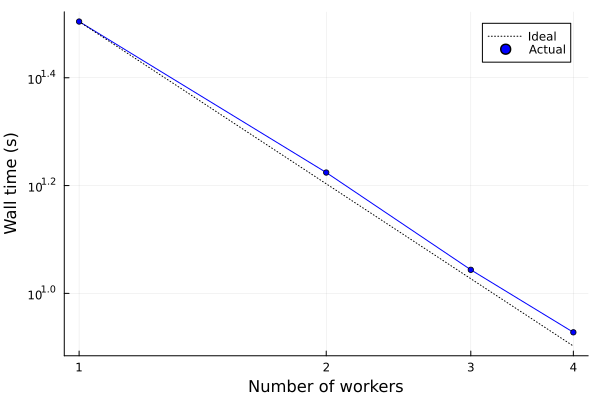

In [28]:
plt = plot(xscale=:log10, yscale=:log10, xticks=(1:num_workers_all, 1:num_workers_all))
plot!(plt, 1:num_workers_all,wall_time, linecolor=:blue, label=:none)
ideal_scaling = wall_time[1]./(1:num_workers_all)
plot!(plt, 1:num_workers_all,ideal_scaling, linecolor=:black, linestyle=:dot, label="Ideal")
scatter!(plt, 1:num_workers_all,wall_time, markersize=3, markercolor=:blue, label="Actual")
xlabel!(plt,"Number of workers")
ylabel!(plt, "Wall time (s)")

In [29]:
if haskey(ENV,"SLURM_JOBID")
    jobid = "_" * ENV["SLURM_JOBID"]
else
    jobid = ""
end;

In [30]:
savefig(plt, "ex2_scaling_" * string(num_workers_all) * jobid * ".png")

"/storage/work/ebf11/Teach/Astro528/Fall2023/lab7-start/ex2_scaling_4_6079270.png"